#### Note:
    Idea is to train network to reduce data dimension to increase auto classification efficient via sklearn models like K-Means or OPTIC and etc..

# Import library

In [1]:
import torch.nn as nn
import torch

from tqdm import tqdm
from IPython.display import clear_output


from torch.optim import Adam
import numpy as np
import pandas as pd
import math
from PIL import Image

import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Import data

In [2]:
# df = pd.read_parquet("../data/experiment_eda.parquet")

train = pd.read_parquet("../data/train_data_features.parquet")
test = pd.read_parquet("../data/test_data_features.parquet")

In [3]:
train.head()

,CLIENT_IP,EVENT_ID,HEADER_pattern,BOT_BOOL,CURL_HEAD_BOOL,WGET_HEAD_BOOL,SYMBOL_@,LENGTH_OF_USER_AGENT_HEAD_likely,windows_bool,linux_bool,...,REQUEST_URI\';\'REQUEST_ARGS,REQUEST_XML,RESPONSE_BODY,RESPONSE_HEADERS,2,3,4,5,Anomaly TOP,user_expected
9497,186.177.157.252,AVdZr3EHq1Ppo9zF1E1J,True,False,False,False,False,True,True,False,...,False,False,False,False,False,True,False,False,False,True
37540,217.175.140.69,1Fu9HGQB5cBXmMW1wjDp,True,False,False,False,False,True,True,False,...,False,False,False,False,True,False,False,False,False,True
49419,90.151.84.224,XK8XJGQB5cBXmMW1Dof6,True,False,False,False,False,True,True,False,...,False,False,False,False,False,False,True,False,False,True
40601,85.234.117.8,x7s9JWQB5cBXmMW1Rmbn,True,False,False,False,False,True,True,False,...,False,False,False,False,False,False,True,False,False,True
9767,195.222.10.251,Ccoc_2MBjksgoq1eTn4W,True,False,False,False,False,True,False,True,...,False,False,False,False,True,False,False,False,False,True


In [4]:
test.head()

,CLIENT_IP,EVENT_ID,HEADER_pattern,BOT_BOOL,CURL_HEAD_BOOL,WGET_HEAD_BOOL,SYMBOL_@,LENGTH_OF_USER_AGENT_HEAD_likely,windows_bool,linux_bool,...,REQUEST_URI\';\'REQUEST_ARGS,REQUEST_XML,RESPONSE_BODY,RESPONSE_HEADERS,2,3,4,5,Anomaly TOP,user_expected
23799,217.175.140.69,a14dHWQB5cBXmMW1Dl2w,True,False,False,False,False,True,True,False,...,False,False,False,False,False,False,False,True,False,True
51955,91.103.66.203,NZo5ImQB5cBXmMW14djt,True,False,False,False,False,True,True,False,...,False,False,False,False,False,False,True,False,False,True
9625,185.70.104.11,AVdqkkhHq1Ppo9zF-FYT,True,False,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,True
22484,95.188.66.154,wMC-E2QBoRd31uenQbLg,True,False,False,False,False,True,True,False,...,False,False,False,False,True,False,False,False,False,True
191,5.19.178.227,joV2IGQB5cBXmMW1JJXD,True,False,False,False,False,True,True,False,...,False,False,False,False,False,False,True,False,False,True


# Prepaire data in CustomDataset for torch

In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __getitem__(self, index):
        row = self.dataframe.iloc[index].to_numpy()
        features = row[2:]
        return  torch.Tensor(features.astype(float)).unsqueeze(0)

    def __len__(self):
        return len(self.dataframe)

In [6]:
# train, test = train_test_split(df, test_size=0.15, train_size=0.75, shuffle=True)

In [7]:
train_dataset, test_dataset = CustomDataset(train), CustomDataset(test)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Define Baseline AutoEncoder

In [9]:
class MLPEncoder(nn.Module):
    def __init__(self, in_channels: int = 1, base_size: int = 42, target_size: int = 10):
        super().__init__()

        self.encoder = nn.Sequential(
                nn.Linear(base_size, base_size-10),
                nn.BatchNorm1d(in_channels),
                nn.Sigmoid(),
                nn.Dropout(0.1),
            
                nn.Linear(base_size-10, base_size-20),
                nn.BatchNorm1d(in_channels),
                nn.Sigmoid(),
                nn.Dropout(0.1),
            
                nn.Linear(base_size-20, target_size),
                nn.BatchNorm1d(in_channels),
                nn.Sigmoid(),
                nn.Dropout(0.1),)
        
        self.decoder = nn.Sequential(
                nn.Linear(target_size, base_size-20),
                nn.BatchNorm1d(in_channels),
                nn.Sigmoid(),
                nn.Dropout(0.1),
            
                nn.Linear(base_size-20, base_size-10),
                nn.BatchNorm1d(in_channels),
                nn.Sigmoid(),
                nn.Dropout(0.1),
            
                nn.Linear(base_size-10, base_size),
                nn.Sigmoid()) 

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    @torch.inference_mode()
    def encode(self, x):
        return self.encoder(x)

    @torch.inference_mode()
    def decode(self, x):
        return self.decoder(x)

# Defain train functions

In [10]:
def train(model):
    model.train()

    train_loss = 0
    batch_size = 32
    for x in tqdm(train_loader, desc='Train'):
        
        x = x.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, x)

        train_loss += loss.detach().item()

        loss.backward()
        optimizer.step()
        
        del loss
        del output

    train_loss /= len(train_loader)

    return train_loss

In [11]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0

    for x in tqdm(loader, desc='Evaluation'):
        x = x.to(device)

        output = model(x)

        loss = loss_fn(output, x)

        total_loss += loss.detach().item()

        del loss
        del output

    total_loss /= len(loader)

    return total_loss

In [12]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Test loss')
    plt.legend()
    plt.grid()

    plt.show()

In [13]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []

    for epoch in range(num_epochs):
        train_loss = train(model)
        valid_loss = evaluate(model, test_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        clear_output(wait=True)

        plot_stats(
            train_loss_history, valid_loss_history,
            title
        )

# SetUp model

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

loss_fn = nn.MSELoss()

cpu


In [27]:
model = MLPEncoder().to(device)
optimizer = Adam(model.parameters(), lr=1e-2)

# Train model

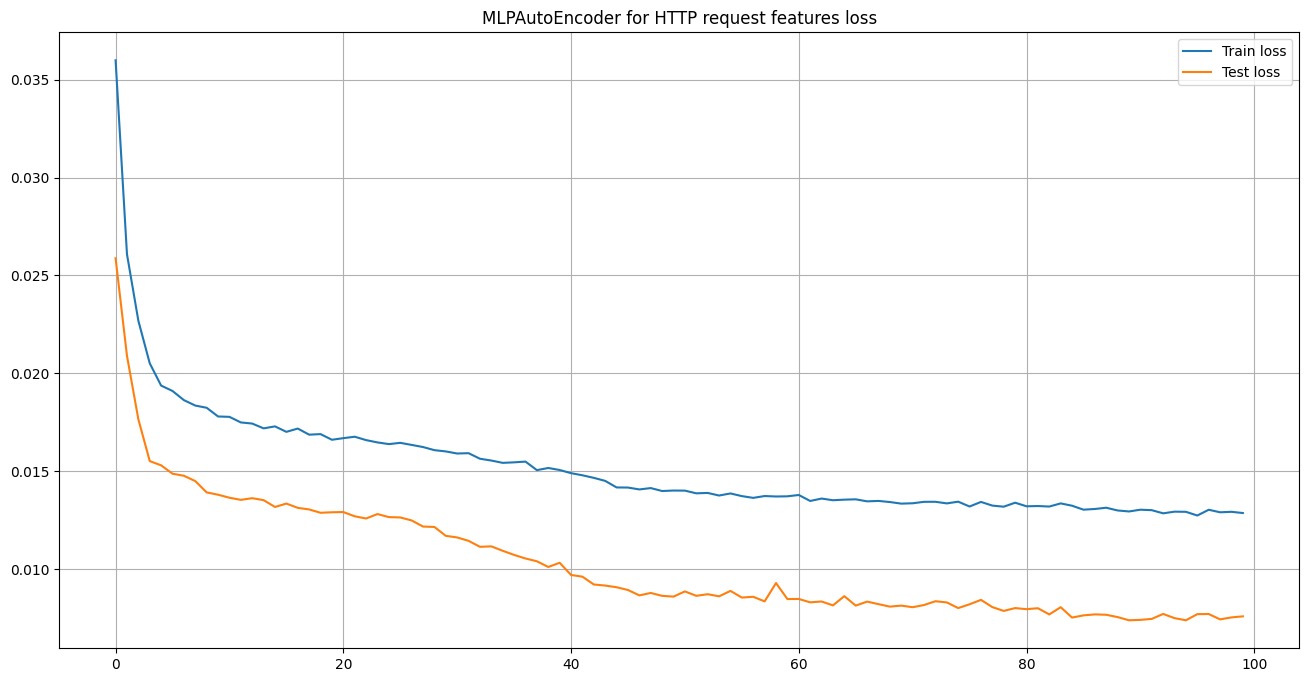

In [28]:
whole_train_valid_cycle(model, 100, 'MLPAutoEncoder for HTTP request features')

# Check model results for a single object of HTTP features from test data

In [29]:
_, x = next(enumerate(test_loader))

In [30]:
@torch.inference_mode()
def check_an_example(x, model):
    sample_of_data = x.view(1,1,42)
    pred = model(sample_of_data)
    return pred

In [51]:
#encode an object from size 42 to 12
model.encode(x[9].view(1,1,42))

tensor([[[4.1508e-01, 9.1718e-01, 7.8343e-02, 2.1216e-10, 7.0938e-01,
          8.1804e-09, 7.7080e-01, 8.2447e-05, 9.4938e-01, 5.7402e-04]]])

In [53]:
#encode -> decode vector
check_an_example(x[9], model).view(1,42).round(decimals=2)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0400,
         0.0400, 0.0000, 0.4500, 0.3000, 0.0000, 1.0000, 0.0600, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000]])

In [54]:
#original vector
x[9]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.4300, 0.3300, 0.0000, 1.0000, 0.0600, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000]])

# Save results

In [55]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('../models/baseline_mlp_autoencdoer.pt') # Save